In [1]:
import sys
import os

# Enable horizontal scrolling for large outputs
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# Calculate the path to your_package
notebook_dir = os.getcwd()
package_dir = os.path.dirname(notebook_dir)

# Add this path to sys.path
if package_dir not in sys.path:
    sys.path.append(package_dir)

In [2]:
from config import parse_args
from main import *

commandline_args = '--task_path=TreeSCAN/v13/mcd2/separate_to_parsed --dtm_layers=20 --steps=3e4 --ctrl_hidden_dim=128 --train_log_freq=20 --max_tree_depth=7 --d_filler=32 --sparse --max_filled_roles=256 --hardcode_cons_root_token="<NT>" --add_eob_to_memory=1 --cons_only=1 --early_stop_epochs=300 --use_wandb --wandb_group=scan_mcd --use_vocab_info=1 --wandb_name=mcd2_untied --batch_size=64 --gclip=5 --lr=1e-4 --optim_beta1=.9 --optim_beta2=.95 --random_positional_max_len=16 --router_dropout=.1 --transformer_nheads=16 --wd=1e-3 --tied_io_languages=0 --filler_noise_location=input --filler_noise_std=1 --is_agent_universal=0 --learn_filler_embed=1'
# XT needs the <NT> token wrapped in "", remove it if it's there
commandline_args = commandline_args.replace('"<NT>"', '<NT>')
args = parse_args(commandline_args.split())
args.batch_size = 1

run = '1266.5'
checkpoint_file = f'/tmp/run{run}/run{run}/mirrored/out/best_checkpoint.pt'

task_path = prepare_data_files(args)
device = 'cpu'
is_ddp = False
main_process = True
data_loaders, input_lang, output_lang = data.prepare_data_loaders(
    task_path,
    args.max_tree_depth,
    args.add_eob_tokens,
    is_ddp,
    args.batch_size,
    args.num_workers,
    data_filter=args.data_filter,
    max_train_examples=args.max_train_examples,
    output_lowercase=args.output_lowercase,
    add_eob_to_memory=args.add_eob_to_memory,
    num_extra_tokens_in_memory=args.num_extra_tokens_in_memory,
)

input_vocab = set(input_lang.ind2vocab.values())  # Set of all unique tokens in the input vocabulary
output_vocab = set(output_lang.ind2vocab.values())  # Set of all unique tokens in the output vocabulary

input_unique_vocab = input_vocab - output_vocab

# Merge the two languages
for i, v in output_lang.ind2vocab.items():
    input_lang.add_word(v)
output_lang = input_lang
for data_loader in data_loaders.values():
    if data_loader:
        data_loader.dataset.output_lang = output_lang

# We always want to mask 0 which is the pad index.
# TODO: pad index should be a variable, I set it to 0 in a few places
output_indices_mask = [0]
# If the languages are not tied, anything unique to the input vocab should be masked out
if not args.tied_io_languages:
    for i, v in output_lang.ind2vocab.items():
        if v in input_unique_vocab:
            output_indices_mask.append(i)
            
test_iter = iter(data_loaders['test'])

print(f'Input language size: {len(input_lang.ind2vocab)}')
print(f'Output language size: {len(output_lang.ind2vocab)}')

max_input_length = -1
for name, loader in data_loaders.items():
    if loader:
        max_input_length = max(max_input_length, loader.dataset.max_input_length)


using LOCAL dataset/task files found at: /Users/psoulos/.data/TreeSCAN/v13/mcd2/separate_to_parsed
Max depth seen in file: 7
8365 training examples
Max depth seen in file: 6
1045 valid examples
Max depth seen in file: 6
1045 test examples
Input language size: 22
Output language size: 22


In [3]:
from TPR_utils import TPR, decoded_tpr_to_tree_fn
from models import DiffTreeMachine
from main import convert_args_to_config

if args.use_vocab_info:
    vocab_info = data.get_vocab_info(args.task_path, output_lang.ind2vocab.values(),)
else:
    vocab_info = {
        'unary': (),
        'binary': (),
        'terminal': ('<EOB>',)
    }

tpr = TPR(
    args,
    num_input_fillers=len(input_lang.ind2vocab),
    num_output_fillers=len(output_lang.ind2vocab),
    num_roles=2 ** args.max_tree_depth,
    d_filler=args.d_filler,
    d_role=args.d_role,
    filler_emb_gain=args.filler_emb_gain,
    learn_empty_filler=args.learn_empty_filler,
    tied_io_languages=args.tied_io_languages,
    empty_filler_initialization=args.empty_filler_initialization,
    device=device,
    sparse=args.sparse,
    nt_token_index=output_lang.vocab2ind.get('<NT>', None),
).to(device=device)


hardcode_cons_root_index = None
if args.hardcode_cons_root_token:
    if args.hardcode_cons_root_token == '-1':
        hardcode_cons_root_index = -1
    else:
        vocab2index = output_lang.vocab2ind
        assert args.hardcode_cons_root_token in vocab2index, (
            f'The token {args.harcode_cons_root_token} is not in the '
            f'vocab.')
        hardcode_cons_root_index = vocab2index[args.hardcode_cons_root_token]
    logger.info(
        f'Hardcoding the root token to {args.hardcode_cons_root_token} with index'
        f' {hardcode_cons_root_index}'
    )


convert_args_to_config(args, input_lang, output_lang, tpr, hardcode_cons_root_index, max_input_length)

dtm = DiffTreeMachine(args).to(device=device)

map_location = device
dtm.load_state_dict(torch.load(checkpoint_file,
                               map_location=map_location)['model'])
dtm.eval()

optimizer, scheduler = setup_optimizer_and_scheduler(dtm, args)

trainer = Trainer(
    dtm,
    tpr,
    data_loaders,
    optimizer,
    args.epoch,
    args.steps,
    args.num_warmup_steps,
    main_process,
    is_ddp,
    decoded_tpr_to_tree_fn(args.tpr_loss_type, sparse=args.sparse),
    torch.nn.CrossEntropyLoss(),
    device,
    output_lang.ind2vocab,
    vocab_info,
    args.use_wandb,
    args.validate_every_num_epochs,
    args.train_log_freq,
    early_stop_epochs=args.early_stop_epochs,
    pad_idx=0,
    sparse=args.sparse,
    scheduler=scheduler,
    gclip=args.gclip,
    lr=args.lr,
    out_dir=args.out_dir,
    best_checkpoint_file=args.best_checkpoint_file,
    most_recent_checkpoint_file=args.most_recent_checkpoint_file,
    use_custom_memory=args.custom_memory,
    cross_entropy_weighting=args.cross_entropy_weighting,
    entropy_regularization_coefficient=args.entropy_regularization_coefficient,
    max_input_length=args.max_input_length,
    nt_token_index=output_lang.vocab2ind.get('<NT>', None),
    eob_token_index=output_lang.vocab2ind.get('<EOB>', None),
    output_indices_mask=output_indices_mask,
)

/Users/psoulos/opt/anaconda3/envs/blackboard2/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trainable params: 4206034


In [4]:
import torch

def print_correct_output(batch):
    output_filler_indices = batch['output_fillers']
    batch_size = output_filler_indices.shape[0]
    output_role_indices = batch['output_roles']
    output_batch_indices = torch.nonzero(output_role_indices, as_tuple=True)[0]
    output_filler_indices = output_filler_indices[output_role_indices != 0]
    output_role_indices = output_role_indices[output_role_indices != 0]
    target = torch.sparse_coo_tensor(indices=torch.stack((output_batch_indices, output_role_indices)),
                                     values=output_filler_indices, size=(batch_size,
                                                                         tpr.num_roles)).coalesce()

    formatted_tree = TreePrettyPrinter(Tree.fromstring(
        batch_symbols_to_node_tree(SparseTPR(target.indices(), target.values()), output_lang.ind2vocab,
                                   terminal_vocab=(),#vocab_info['terminal'],
                                   unary_vocab=vocab_info['unary'], )[0].str(), ))
    print('Correct output:\n{}'.format(formatted_tree.text()))

In [5]:
def make_output_lowercase(args, string):
    out = []
    if args.output_lowercase:
        for s in string:
            if s == 'I_JUMP':
                out.append('jump')
            if s == 'I_WALK':
                out.append('walk')
            if s == 'I_LOOK':
                out.append('look')
            if s == 'I_RUN':
                out.append('run')
            if s == 'I_TURN_RIGHT':
                out.append('right')
            if s == 'I_TURN_LEFT':
                out.append('left')
    else:
        out = string
    return out

In [10]:
batch = next(test_iter)
#print(batch)
_ = trainer.process_batch(batch, debug=True)
print_correct_output(batch)
print(f'Correct? {_[3]}')

Step 0:
Blackboard:
[cons_l, cons_r]
 0	[.00 .78]    (  )
 1	[.00 .01]    ( run )
 2	[.00 .00]    ( left )
 3	[.00 .02]    ( twice )
 4	[.00 .00]    ( and )
 5	[.00 .01]    ( walk )
 6	[.99 .02]    ( right )
 7	[.01 .16]    ( twice )
Output: 
```turn
 |   
... 
```
Step 1:
Blackboard:
[cons_l, cons_r]
 0	[.01 .73]    (  )
 1	[.00 .20]    ( run )
 2	[.23 .00]    ( left )
 3	[.07 .02]    ( twice )
 4	[.35 .00]    ( and )
 5	[.01 .00]    ( walk )
 6	[.24 .00]    ( right )
 7	[.08 .03]    ( twice )
 8	[.00 .01]  0. ( turn )
Output: 
```turn
 |   
... 
```
Step 2:
Blackboard:
[cons_l, cons_r]
 0	[.00 .00]    (  )
 1	[.00 .00]    ( run )
 2	[.06 .07]    ( left )
 3	[.06 .03]    ( twice )
 4	[.26 .23]    ( and )
 5	[.01 .01]    ( walk )
 6	[.45 .56]    ( right )
 7	[.16 .09]    ( twice )
 8	[.00 .00]  0. ( turn )
 9	[.00 .00]  1. ( turn )
Output: 
```turn
 |   
... 
```
Step 3:
Blackboard:
[cons_l, cons_r]
 0	[.00 .02]    (  )
 1	[.01 .97]    ( run )
 2	[.85 .00]    ( left )
 3	[.05 .00]    (

In [76]:
_ = trainer.process_batch(batch, debug=True)
print_correct_output(batch)
print(f'Correct? {_[3]}')

Step 0:
Blackboard:
 0	[.18 .05]    (  )
 1	[.09 .06]    ( run )
 2	[.15 .27]    ( around )
 3	[.12 .05]    ( right )
 4	[.06 .09]    ( twice )
 5	[.12 .04]    ( and )
 6	[.08 .08]    ( run )
 7	[.15 .20]    ( around )
 8	[.06 .15]    ( left )
Output: 
```       <NT>       
   _____|_____     
around      around
```
Step 1:
Blackboard:
 0	[.02 .01]    (  )
 1	[.01 .10]    ( run )
 2	[.08 .01]    ( around )
 3	[.05 .00]    ( right )
 4	[.35 .01]    ( twice )
 5	[.01 .01]    ( and )
 6	[.03 .30]    ( run )
 7	[.33 .02]    ( around )
 8	[.11 .01]    ( left )
 9	[.02 .54]  0. ( <NT> around around )
Output: 
```            <NT>      
      _______|_____    
I_TURN_LEFT      I_RUN
```
Step 2:
Blackboard:
 0	[.04 .01]    (  )
 1	[.01 .04]    ( run )
 2	[.18 .01]    ( around )
 3	[.06 .01]    ( right )
 4	[.20 .03]    ( twice )
 5	[.02 .01]    ( and )
 6	[.01 .24]    ( run )
 7	[.23 .08]    ( around )
 8	[.04 .05]    ( left )
 9	[.03 .13]  0. ( <NT> around around )
10	[.19 .39]  1. ( <NT> I_TU

In [ ]:
incorrect_samples = []
for batch in test_iter:
    _ = trainer.process_batch(batch, debug=False)
    if _[3][0] == False:
        input_string = []
        for token_idx in batch['input_fillers'][0]:
            input_string.append(input_lang.ind2vocab[token_idx.item()])
        incorrect_samples.append(' '.join(input_string))
    if _[3][1] == False:
        input_string = []
        for token_idx in batch['input_fillers'][1]:
            input_string.append(input_lang.ind2vocab[token_idx.item()])
        incorrect_samples.append(' '.join(input_string))

In [ ]:
for i in incorrect_samples:
    print(i)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('walk around left thrice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_tree = text_tree_to_node('( <NT> ( <NT> ( <NT> ( <NT> ( <NT> left jump ) ( <NT> left jump ) ) ( <NT> ( <NT> left jump ) ( <NT> left jump ) ) ) ( <NT> ( <NT> ( <NT> left jump ) ( <NT> left jump ) ) ( <NT> ( <NT> left jump ) ( <NT> left jump ) ) ) ) ( <NT> ( <NT> ( <NT> ( <NT> left jump ) ( <NT> left jump ) ) ( <NT> ( <NT> left jump ) ( <NT> left jump ) ) ) ) )', add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('turn around left thrice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)

out_string = '( <NT> ( <NT> ( <NT> ( <NT> I_TURN_RIGHT I_TURN_RIGHT ) ( <NT> I_TURN_RIGHT I_TURN_RIGHT ) ) ( <NT> ( <NT> I_TURN_RIGHT I_TURN_RIGHT ) ( <NT> I_TURN_RIGHT I_TURN_RIGHT ) ) ) ( <NT> ( <NT> I_TURN_RIGHT I_TURN_RIGHT ) ( <NT> I_TURN_RIGHT I_TURN_RIGHT ) ) )'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [ ]:
output = _[-1]
x_decoded = decoded_tpr_to_tree_fn(args.tpr_loss_type, sparse=args.sparse)(
    tpr.unbind(
        (SparseTPR(output.indices(), output.values())), decode=True, type_='output'
    )
)
debug_tree = batch_symbols_to_node_tree(
    x_decoded,
    output_lang.ind2vocab,
    terminal_vocab=(),#vocab_info['terminal'],
    unary_vocab=(),#vocab_info['unary']
)[0]
pretty_tree = TreePrettyPrinter(Tree.fromstring(debug_tree.str()))
print(pretty_tree.text())

In [ ]:
print(output.indices())
(output.values()[int('11',2)]@tpr.out.weight.T).argmax()

In [ ]:
role = int('1110000',2)
print(role)
print(output.role_indices()[role-1])
print((output.values()[role-1]@tpr.out.weight.T).argmax())
print(output_lang.ind2vocab[(output.values()[role-1]@tpr.out.weight.T).argmax().item()])

In [ ]:
output_lang.ind2vocab[2]

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('walk around right twice and jump opposite left twice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_string = 'I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('look around right thrice after walk around left twice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_string = 'I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('walk around left twice and look around right thrice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_string = 'I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('walk around right thrice and jump left twice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_string = 'I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
#print_correct_output(input_)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('walk around right thrice and jump opposite left twice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_string = 'I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
#print_correct_output(input_)

In [ ]:
from data import text_tree_to_node, BinaryT2TDataset
from preprocessing.preprocess_scan import build_leaves_tree, build_separate_tree

in_tree = text_tree_to_node(build_separate_tree('walk around right thrice and jump around left thrice'.split()), add_eob_to_memory=args.add_eob_to_memory, add_eob_tokens=args.add_eob_tokens)
out_string = 'I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP'.split()
out_string = make_output_lowercase(args, out_string)
out_tree = text_tree_to_node(build_leaves_tree(out_string), add_eob_to_memory=False, add_eob_tokens=args.add_eob_tokens)
example = {"input": in_tree, "output": out_tree}
item = example

input_roles, input_fillers = data_loaders['train'].dataset.text_to_tensors(item['input'], language=input_lang)
output_roles, output_fillers = data_loaders['train'].dataset.text_to_tensors(item['output'], language=output_lang)
input_ = {
    'input_fillers': input_fillers.unsqueeze(0),
    'input_roles': input_roles.unsqueeze(0),
    'output_fillers': output_fillers,
    'output_roles': output_roles,
}

_ = trainer.process_batch(input_, debug=True)
print_correct_output(input_)

In [ ]:
for i, filler in enumerate(zip(output_lang.ind2vocab, tpr.out.weight.norm(dim=-1))):
    print(f'{i}. {filler[0]} {filler[1]}')


In [ ]:
for i in range(tpr.out.weight.shape[0]):
    print(f'{i}. {(tpr.filler_emb.weight[14]*.7+tpr.filler_emb.weight[4]*.3) @ tpr.out.weight[i]}')

In [ ]:
for i in range(tpr.out.weight.shape[0]):
    print(f'{i}. {tpr.filler_emb.weight[7] @ tpr.out.weight[i]}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Generating a new colormap
colors = ["green", "white", "blue"]  # green for negative, white for zero, blue for positive
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)



# Compute the dot product matrix
dot_product_matrix = tpr.out.weight @ tpr.out.weight.T

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(dot_product_matrix.detach(), cmap=cm, interpolation='nearest')
plt.title("Heatmap of Dot Products Between Vectors")
plt.colorbar()
plt.show()

In [11]:
for i in range(len(output_lang.ind2vocab)):
    print(f'{i}.{output_lang.ind2vocab[i]}: {tpr.out.weight[i] @ tpr.out.weight.T}')

0.<PAD>: tensor([ 38.4643,  -1.2650,  -5.4340,  -0.5567,   5.3178,  -0.8213,  -3.9879,
         -1.0876,   6.0718,  14.7181,   2.2179,   0.9877,  -3.7879, -13.8010,
          3.9467,  -2.6295,   0.9428,  -2.9094,  -5.3936,  -2.6868,   1.5483,
         -4.3621], grad_fn=<SqueezeBackward4>)
1.<EOB>: tensor([-1.2650, 20.5778, -2.0953, -0.9108, -1.4918, -0.9853,  7.2510,  4.7910,
         6.8129, -0.6118,  0.2910, -4.8803, -7.2999,  0.4109,  6.9162, -0.3009,
         0.6713, -0.7813, -1.3780, -3.9194, -3.9894,  0.3352],
       grad_fn=<SqueezeBackward4>)
2.look: tensor([ -5.4340,  -2.0953,  32.9633,  -5.3247,  -1.7601, -12.8474,  -5.6252,
          9.6618,  -9.4450,  -3.1975,  -7.2421,  -1.6947,  -0.0611,   2.4653,
        -11.6218,  -6.3457,   0.6665,  -4.7231,  -2.8646,  -6.2134,   1.5972,
          1.3260], grad_fn=<SqueezeBackward4>)
3.around: tensor([-0.5567, -0.9108, -5.3247, 32.8120,  7.4140,  0.5578,  3.9617, -5.1256,
        13.5329,  8.7502, 13.2390,  0.8700, -2.3974, -0.9883, -4

In [13]:
for i in range(len(input_lang.ind2vocab)):
    print(f'{i}.{input_lang.ind2vocab[i]}: {tpr.filler_emb.weight[i] @ tpr.out.weight.T}')

0.<PAD>: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SqueezeBackward4>)
1.<EOB>: tensor([-1.0720e+01, -2.7801e+00, -3.6761e+00,  1.6538e+00,  1.8160e-01,
        -9.4147e+00, -7.9501e+00, -1.1604e+01, -2.8610e-01, -1.2316e+01,
        -6.3278e+00, -5.8425e+00,  2.4923e+00,  3.9381e+00,  7.9339e-01,
        -3.3111e+00, -7.6818e+00, -9.4085e-03,  3.0352e+01, -9.5905e+00,
         1.5584e+00, -4.3065e+00], grad_fn=<SqueezeBackward4>)
2.look: tensor([  0.4390,  -1.3106,  -6.2304,  -0.8247,  -0.7065,   1.5454,   7.3668,
        -11.8279,  -0.6073,   3.3067,  -5.7260,   7.7406,   7.0424,   6.9656,
          1.2654,  -6.4022,   0.2681,  30.0977,  -2.2710,   2.8627,  -4.4965,
         -0.3888], grad_fn=<SqueezeBackward4>)
3.around: tensor([ 4.5561, -1.8050, -7.5770,  4.7219, -8.0189,  3.6592,  7.3560, -5.0852,
         5.5438, 12.8537, -0.3296,  3.7233,  9.9698, -3.5054,  1.7896,  2.8742,
        -3.0140, 17.9360,  2.0051,  

In [20]:
print(tpr.out.weight[1])
print(tpr.filler_emb.weight[1])

tensor([ 2.2672, -0.2893, -0.2888, -1.0933, -0.9182, -0.0711, -0.1466,  0.4274,
         0.3078,  1.5727, -0.6175, -0.1820,  1.2833, -0.1919, -1.0855, -0.6574,
         0.1859,  1.1429,  0.0777,  0.5741,  0.4500, -0.6082,  0.6319,  0.8965,
        -0.4301,  0.2460, -0.3725,  0.7206, -0.0446,  1.2992, -0.7116, -0.4412],
       grad_fn=<SelectBackward0>)
tensor([-1.3089e-01, -5.7628e-01,  8.6113e-01, -4.8879e-01, -1.7765e+00,
         6.0410e-01,  1.9270e+00, -7.4220e-01, -1.9269e-01, -4.8409e-01,
        -2.0133e+00, -5.4910e-01,  1.7669e-03,  5.6774e-01,  1.7815e+00,
        -1.1149e+00,  4.9377e-02, -5.5262e-01, -1.5921e+00, -2.0102e+00,
        -1.0489e-01, -1.0845e+00, -1.7015e+00,  1.8746e-01, -1.7703e+00,
         1.4604e+00, -2.8480e+00,  3.6574e-01,  1.6097e+00, -1.6735e+00,
         1.0968e+00,  8.2292e-01], grad_fn=<SelectBackward0>)


In [ ]:
tpr.filler_emb.weight[7] @ tpr.out.weight.T

In [ ]:
a = torch.tensor([ 0.0764,  0.5909, -0.9669,  0.0574, -0.9311, -1.0875, -0.3789, -0.1703,
        -0.1916,  1.4145, -0.1150,  0.5652, -0.4569,  0.3671, -1.0746, -1.1743,
         0.1241, -1.1443, -1.3893, -0.8754, -1.3105,  0.0818, -0.1234,  0.3814,
         0.5174, -0.9131, -0.7015,  0.2231, -1.2841, -0.0058,  0.7574, -0.4444,
         0.1757, -0.2283,  0.0047, -0.2394, -0.2723, -0.1466,  0.4142, -0.1406,
        -0.1118, -1.0626, -0.1752,  0.1124, -0.5517, -0.6271, -0.3438, -0.3370,
        -0.1784,  1.4131, -1.1570,  0.4874, -1.0664,  0.3588,  0.0939,  0.1241,
        -0.6608,  1.2563,  0.7050,  0.7262, -0.2961, -1.1610,  0.1476, -0.6420])
f = a @ tpr.out.weight.T
for i, v in enumerate(f):
    print(f'{i}: {v}')


In [15]:
tpr.filler_emb.weight.norm(dim=-1)

tensor([0.0000, 7.5270, 7.1935, 6.6085, 6.4812, 8.0699, 7.1930, 6.7274, 6.6540,
        7.6874, 6.7856, 6.5155, 6.6383, 7.2399, 6.9502],
       grad_fn=<LinalgVectorNormBackward0>)

In [96]:
print('INPUT')
for key, value in input_lang.ind2vocab.items():
    print(f'{key}: {value}\t{tpr.filler_emb.weight[key].norm()}')
print('OUTPUT')
for key, value in output_lang.ind2vocab.items():
    print(f'{key}: {value}')

INPUT
0: <PAD>	0.0
1: <EOB>	6.772979259490967
2: walk	6.629185676574707
3: jump	6.799426555633545
4: look	6.7559051513671875
5: turn	6.749093055725098
6: right	6.846651077270508
7: run	6.7497172355651855
8: left	6.651447296142578
9: after	6.444584846496582
10: twice	7.076009273529053
11: opposite	6.667144775390625
12: and	6.627182960510254
13: thrice	6.349668502807617
14: around	7.411162376403809
15: I_WALK	8.431873321533203
16: I_JUMP	8.459897994995117
17: I_LOOK	8.417386054992676
18: I_TURN_RIGHT	8.7301607131958
19: I_RUN	8.258684158325195
20: I_TURN_LEFT	9.644865036010742
21: <NT>	4.809088230133057
OUTPUT
0: <PAD>
1: <EOB>
2: walk
3: jump
4: look
5: turn
6: right
7: run
8: left
9: after
10: twice
11: opposite
12: and
13: thrice
14: around
15: I_WALK
16: I_JUMP
17: I_LOOK
18: I_TURN_RIGHT
19: I_RUN
20: I_TURN_LEFT
21: <NT>


In [ ]:
print(tpr.filler_emb.weight.norm(dim=-1))

In [ ]:
torch.linalg.matrix_rank(tpr.out.weight)

## Visualize Embeddings

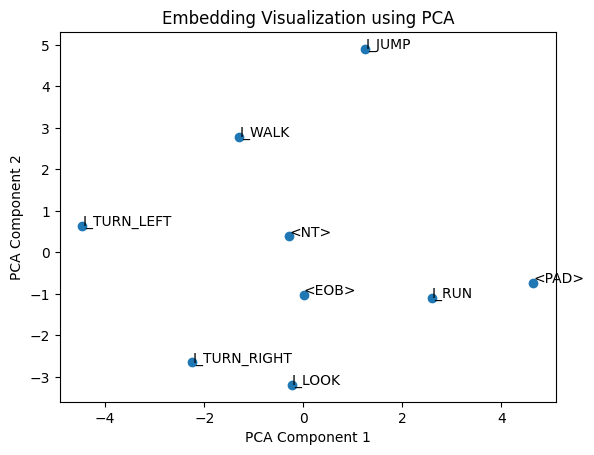

In [16]:
embeddings = tpr.out.weight.data.numpy()
from sklearn.decomposition import PCA

#output_indices = [10,11,12,13,16,21]

pca = PCA(n_components=2)  # for 2D visualization
reduced_embeddings = pca.fit_transform(embeddings)
import matplotlib.pyplot as plt

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# Annotate each point
for i, label in enumerate(output_lang.ind2vocab):
    plt.annotate(output_lang.ind2vocab[label], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title('Embedding Visualization using PCA')
plt.show()

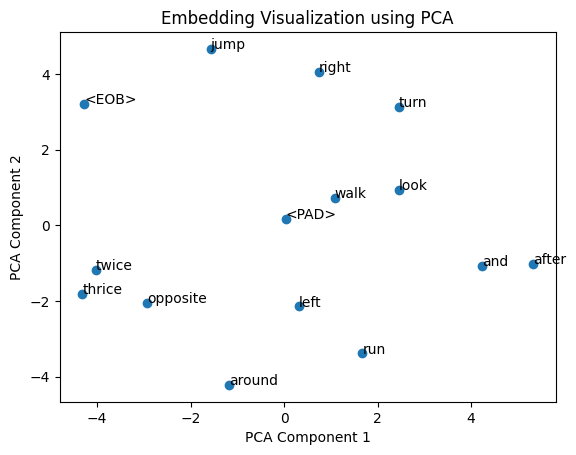

In [17]:
embeddings = tpr.filler_emb.weight.data.numpy()
from sklearn.decomposition import PCA

#output_indices = [10,11,12,13,16,21]

pca = PCA(n_components=2)  # for 2D visualization
reduced_embeddings = pca.fit_transform(embeddings)
import matplotlib.pyplot as plt

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# Annotate each point
for i, label in enumerate(input_lang.ind2vocab):
    plt.annotate(input_lang.ind2vocab[label], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title('Embedding Visualization using PCA')
plt.show()

In [ ]:
torch.linalg.matrix_rank(tpr.filler_emb.weight)

In [ ]:
Tree.fromstring('(NT I_WALK I_JUMP)').pretty_print()

In [ ]:
Tree.fromstring('( COMMAND ( PHRASE ( VERB ( ACTION jump ) ) ) )	( CX ( PX ( VX ( AX I_JUMP ) ) ) )')